# Guided Project: Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Here are the descriptions for the relevant columns:

    instant - A unique sequential ID number for each row
    dteday - The date of the rentals
    season - The season in which the rentals occurred
    yr - The year the rentals occurred
    mnth - The month the rentals occurred
    hr - The hour the rentals occurred
    holiday - Whether or not the day was a holiday
    weekday - The day of the week (as a number, 0 to 7)
    workingday - Whether or not the day was a working day
    weathersit - The weather (as a categorical variable)
    temp - The temperature, on a 0-1 scale
    atemp - The adjusted temperature
    hum - The humidity, on a 0-1 scale
    windspeed - The wind speed, on a 0-1 scale
    casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
    registered - The number of registered riders (people who had already signed up)
    cnt - The total number of bike rentals (casual + registered)

In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.

In [1]:
#import necessary libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#import data into pandas and explore first few rows
bike_rentals = pd.read_csv('bike_rental_hour.csv')

bike_rentals.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


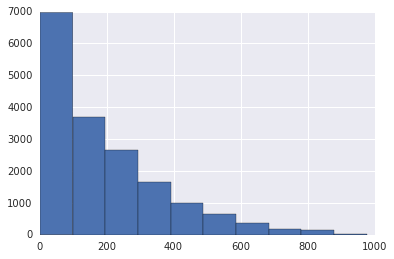

In [3]:
bike_rentals['cnt'].hist()


weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


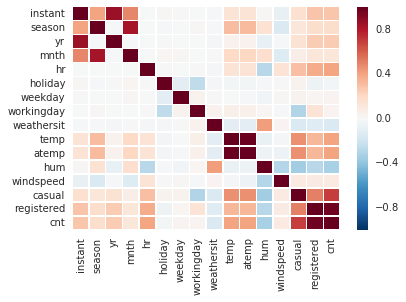

In [4]:
#correlations with cnt column
corr=bike_rentals.corr()
ax = sns.heatmap(corr, linewidths=.5)
cnt_corr=np.abs(corr['cnt']).sort_values()
print(cnt_corr)

The hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine treats each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This bundles similar times together, enabling the model to make better decisions.

Let us write a function called assign_label that takes in a numeric value for an hour, and returns: 
    - 1 if the hour is from 6 to 12
    - 2 if the hour is from 12 to 18
    - 3 if the hour is from 18 to 24
    - 4 if the hour is from 0 to 6

In [5]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

#apply to hours column
bike_rentals['time_label']=bike_rentals['hr'].apply(assign_label)
bike_rentals['time_label'].head(20)

0     4
1     4
2     4
3     4
4     4
5     4
6     1
7     1
8     1
9     1
10    1
11    1
12    2
13    2
14    2
15    2
16    2
17    2
18    3
19    3
Name: time_label, dtype: int64

## Error Metric

Mean Squared Error makes the most sense to use as our data is numerical and continuous in general.

In [6]:
#split into training and test sets
train=bike_rentals.sample(frac=0.8)
test_index=bike_rentals.index.isin(train.index)
test=bike_rentals.loc[~test_index]
print('Train set information')
print(train.info())
print('----------------------------------------')
print('Test set information')
print(test.info())

Train set information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 13956 to 4216
Data columns (total 18 columns):
instant       13903 non-null int64
dteday        13903 non-null object
season        13903 non-null int64
yr            13903 non-null int64
mnth          13903 non-null int64
hr            13903 non-null int64
holiday       13903 non-null int64
weekday       13903 non-null int64
workingday    13903 non-null int64
weathersit    13903 non-null int64
temp          13903 non-null float64
atemp         13903 non-null float64
hum           13903 non-null float64
windspeed     13903 non-null float64
casual        13903 non-null int64
registered    13903 non-null int64
cnt           13903 non-null int64
time_label    13903 non-null int64
dtypes: float64(4), int64(13), object(1)
memory usage: 2.0+ MB
None
----------------------------------------
Test set information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3476 entries, 1 to 17368
Data columns (total 18

In [7]:
def get_features():
    '''
    get prediction columns based on different correlation thresholds
    '''
    predictors = list(train.columns)
    predictors.remove("cnt")
    predictors.remove("casual")
    predictors.remove("registered")
    predictors.remove("dteday")
    return predictors
get_features()

['instant',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label']

## Linear Regression model 

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [9]:
#use pred_cols as features
def LR_train_and_test(features):
    
    reg=LinearRegression().fit(train[features], train['cnt'])
    predictions=reg.predict(test[features])
    
    mse=mean_squared_error(test['cnt'], predictions)
    rmse=np.sqrt(mse)
    return rmse


In [10]:
print('Rmse is:',\
      LR_train_and_test(get_features()))

Rmse is: 128.58494406651337


The error is clearly very high, showing that perhaps Linear Regression is not the best method in this case. 

## Decision Trees

In [11]:
from sklearn.tree import DecisionTreeClassifier


In [12]:
def DT_train_and_test(features, leaves=2, depth=None):
    dt=DecisionTreeClassifier(min_samples_leaf=leaves, max_depth=depth)
    dt.fit(train[features], train['cnt'])
    predictions=dt.predict(test[features])
    
    mse=np.mean((predictions - test["cnt"]) ** 2)
    rmse=np.sqrt(mse)
    var=np.var(predictions)
    return rmse, var

### Varying number of min_samples_leaf and max_depth

In [13]:
print('min_samples_leaf=2, then rmse, variance is:',\
      DT_train_and_test(get_features(),leaves=2, depth=None))
print('min_samples_leaf=5, then rmse, variance is:',\
      DT_train_and_test(get_features(),leaves=5, depth=None))
print('min_samples_leaf=7, then rmse, variance is:',\
      DT_train_and_test(get_features(),leaves=7, depth=None))
print('min_samples_leaf=10, then rmse, variance is:',\
      DT_train_and_test(get_features(),leaves=10, depth=None))

min_samples_leaf=2, then rmse, variance is: (79.65293856100924, 26496.652563493084)
min_samples_leaf=5, then rmse, variance is: (91.60850684866868, 24485.379641808166)
min_samples_leaf=7, then rmse, variance is: (90.9442965490339, 25294.766983133395)
min_samples_leaf=10, then rmse, variance is: (93.7017555189964, 26197.535589347834)


2 leaves seems to perform best, now let us vary the depth

In [14]:
print('max_depth=5, then rmse, variance is:',\
      DT_train_and_test(get_features(),depth=5))
print('max_depth=10, then rmse, variance is:',\
      DT_train_and_test(get_features(),depth=10))
print('max_depth=20, then rmse, variance is:',\
      DT_train_and_test(get_features(),depth=20))
print('min_samples_leaf=50, then rmse, variance is:',\
      DT_train_and_test(get_features(),depth=50))

max_depth=5, then rmse, variance is: (137.42004998576357, 9414.036666353268)
max_depth=10, then rmse, variance is: (99.68392799531614, 25631.042358765215)
max_depth=20, then rmse, variance is: (83.14757701049241, 25675.78254926764)
min_samples_leaf=50, then rmse, variance is: (76.8096053730288, 26973.10276815143)


## Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor 

In [17]:
def RF_train_and_test(features, trees=100):
    rf=RandomForestRegressor(n_estimators=trees)
    rf.fit(train[features], train['cnt'])
    predictions=rf.predict(test[features])
    
    mse=np.mean((predictions - test["cnt"]) ** 2)
    rmse=np.sqrt(mse)
    var=np.var(predictions)
    return rmse, var

In [ ]:
print('n_estimators=5, then rmse, variance is:',\
      RF_train_and_test(get_features(),trees=5))
print('n_estimators=20, then rmse, variance is:',\
      RF_train_and_test(get_features(),leaves=5, depth=None))
print('n_estimators=50, then rmse, variance is:',\
      RF_train_and_test(get_features(),leaves=7, depth=None))
print('n_estimators=100, then rmse, variance is:',\
      RF_train_and_test(get_features(),leaves=10, depth=None))
print('n_estimators=500, then rmse, variance is:',\
      RF_train_and_test(get_features(),leaves=10, depth=None))